In [1]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
from scipy import signal
from operator import attrgetter
from functools import reduce

GRAY_CONVERTER = np.array([0.2989, 0.5870, 0.1140])
EPSILON = np.finfo(float).eps

train_path = r'.\Group_1\train'
test_path = r'.\Group_1\test'


In [2]:
image = matplotlib.image.imread(os.path.join(train_path, 'bird', '0000.jpg'))


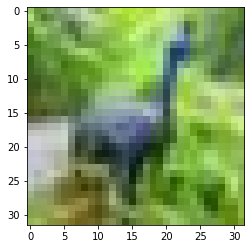

In [3]:
plt.imshow(image)
plt.show()

In [4]:
def relu(x):
    return np.where(x >= 0, x, 0)


def sigmoid(x):
    return np.apply_along_axis(lambda a: 1 / (1 + np.exp(-a)), 0, x)


def convert_to_gray(image):
    return np.dot(image[..., :3], GRAY_CONVERTER)


def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


In [5]:
grayscale_image = convert_to_gray(image)


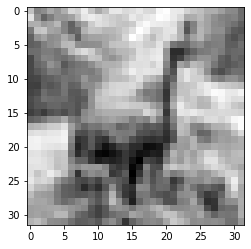

In [6]:
plt.imshow(grayscale_image, cmap=plt.get_cmap('gray'))
plt.show()

In [22]:
class ConvolutionLayer:
    def __init__(self, H2=2, W2=2, D2=1, K=1):
        self.H2 = H2
        self.W2 = W2
        self.D2 = D2
        self.K = K
        self.filters = np.random.normal(scale=0.3, size=(K, H2, W2, D2)) / (H2 * W2 * D2)
        self.bias = np.zeros(shape=(K, ))

    def iterate_regions(self, input):
        H1, W1, _ = input.shape

        H2, W2, D2 = attrgetter('H2', 'W2', 'D2')(self)

        for i in range(H1 - H2 + 1):
            for j in range(W1 - W2 + 1):
                section = input[i: i + H2, j: j + W2]
                yield section, i, j

    def forward(self, input):
        H1, W1, _ = input.shape

        self.last_input = input

        H2, W2, D2, K, filters, bias = attrgetter(
            'H2', 'W2', 'D2', 'K', 'filters', 'bias')(self)

        feature_maps = np.zeros(((H1 - H2 + 1), (W1 - W2 + 1), K))

        for section, i, j in self.iterate_regions(input):
            feature_maps[i, j] += np.sum(section
                                             * filters, axis=(1, 2, 3))

        feature_maps += bias

        return feature_maps


In [23]:
conv_layer1 = ConvolutionLayer(3, 3, 3, 32)
conv_layer2 = ConvolutionLayer(3, 3, 32, 64)

In [24]:
out1 = conv_layer1.forward(image / 255.0)
a_out1 = relu(out1)
out2 = conv_layer2.forward(a_out1)
a_out2 = relu(out2)

Outputs for Layer 1


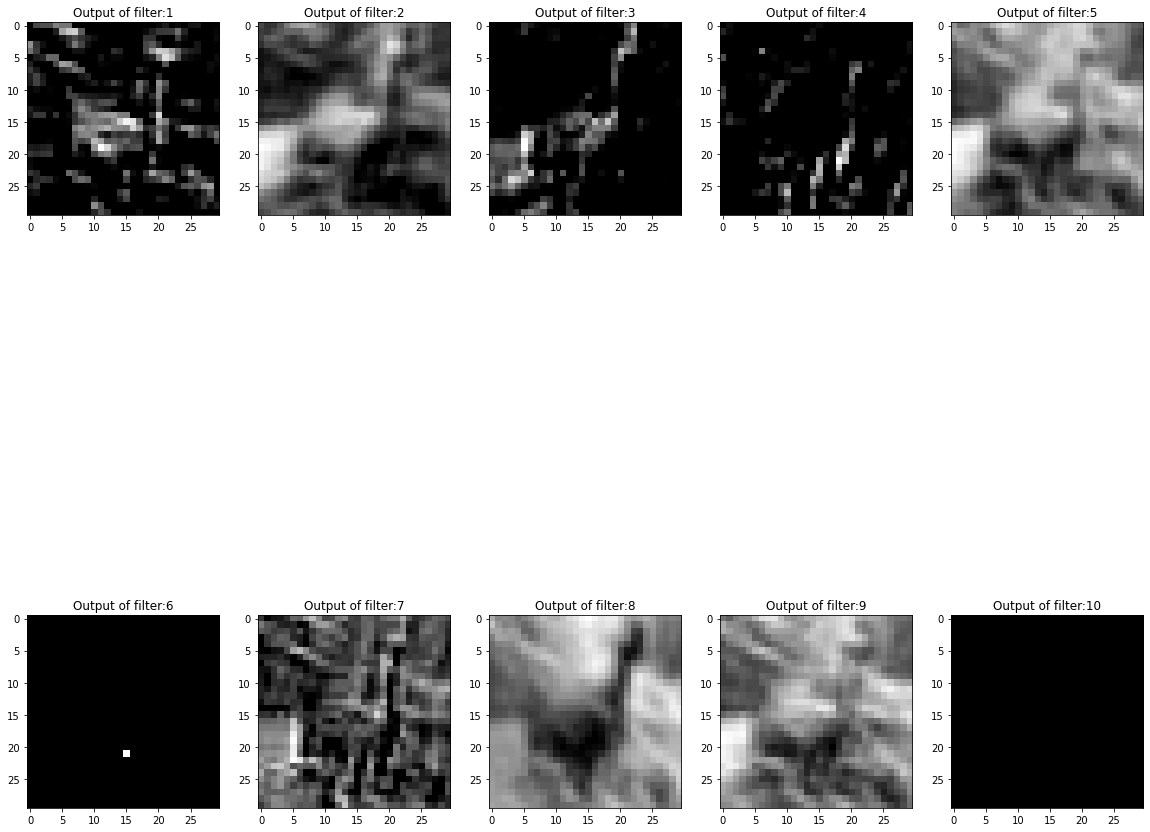

In [25]:
print("Outputs for Layer 1")
fig, axs = plt.subplots(2, 5, figsize=(20, 20), facecolor='white')


for i, ax in enumerate(axs.flat):
    ax.imshow(a_out1[:, :, i], cmap=plt.get_cmap('gray'))
    ax.set_title('Output of filter:{}'.format(i + 1))

plt.show()


Outputs for Layer 2


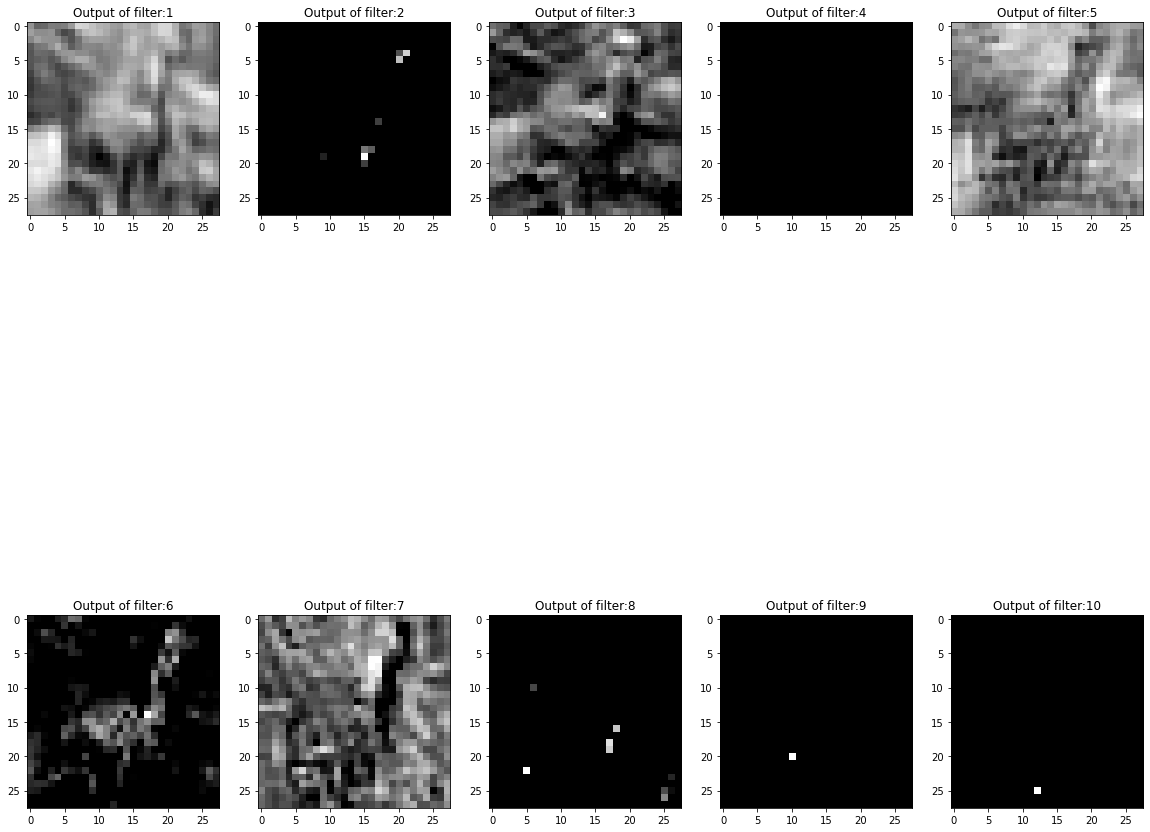

In [26]:
print("Outputs for Layer 2")
fig, axs = plt.subplots(2, 5, figsize=(20, 20), facecolor='white')


for i, ax in enumerate(axs.flat):
    ax.imshow(a_out2[:, :, i], cmap=plt.get_cmap('gray'), )
    ax.set_title('Output of filter:{}'.format(i + 1))
    
plt.show()

In [27]:
print(a_out1.shape)

(30, 30, 32)


In [28]:
print(a_out2.shape)

(28, 28, 64)


In [21]:
print(a_out1[:, :, :10])

[[[11.97338166  1.75680466  0.         ...  8.93940022 12.67748784
    6.20097139]
  [14.20695681  1.63641187  0.         ...  5.3357147   8.03387204
    3.97814328]
  [15.55287056  1.37725559  0.         ...  3.89445918  6.08284366
    2.70582703]
  ...
  [11.83979203  1.32468182  0.         ...  7.18964642  8.09977731
    2.38093495]
  [12.08372496  1.43671436  0.         ...  6.59497464  7.11955289
    1.97859601]
  [11.08937545  1.31630076  0.         ...  6.12266703  7.61037616
    2.60189351]]

 [[13.4959683   0.67405684  0.         ...  7.7430742   8.19524037
    3.13534249]
  [12.85424679  1.54752202  0.         ...  7.00246927 10.47810544
    5.96528911]
  [13.80549651  2.392977    0.         ...  5.72173732 10.06123592
    5.5994369 ]
  ...
  [10.92397027  1.29444495  0.         ...  6.64552266  8.26550285
    3.6188061 ]
  [11.02483329  1.6489402   0.         ...  6.39889161  8.10164947
    2.93198727]
  [10.40535793  1.41981504  0.         ...  5.72015093  7.35078205
    2.

In [59]:
print(a_out2[:, :, :10])

[[[0.00000000e+00 0.00000000e+00 1.32794909e-04 ... 1.56689389e-04
   0.00000000e+00 1.31907559e-05]
  [0.00000000e+00 0.00000000e+00 1.20922433e-04 ... 1.37875669e-04
   0.00000000e+00 7.41024330e-06]
  [0.00000000e+00 0.00000000e+00 1.12860494e-04 ... 9.83239567e-05
   0.00000000e+00 6.44310147e-05]
  ...
  [0.00000000e+00 0.00000000e+00 1.68520284e-04 ... 7.70119834e-06
   0.00000000e+00 6.16719869e-05]
  [0.00000000e+00 0.00000000e+00 1.89734593e-04 ... 7.75410257e-05
   0.00000000e+00 6.72482871e-05]
  [0.00000000e+00 0.00000000e+00 1.68095750e-04 ... 6.04872527e-05
   0.00000000e+00 7.17518107e-05]]

 [[0.00000000e+00 0.00000000e+00 1.88116304e-05 ... 1.94841492e-04
   0.00000000e+00 1.13121502e-04]
  [0.00000000e+00 0.00000000e+00 4.15929605e-05 ... 3.98386136e-05
   0.00000000e+00 1.30072010e-04]
  [0.00000000e+00 0.00000000e+00 8.77242711e-05 ... 0.00000000e+00
   0.00000000e+00 1.48888512e-04]
  ...
  [0.00000000e+00 0.00000000e+00 9.27818505e-05 ... 3.67631457e-05
   0.00000